In [1]:
!pip install -U langgraph langchain_google_genai langchain_community

In [2]:
import getpass
import os
if 'GOOGLE_API_KEY' not in os.environ:
   os.environ['GOOGLE_API_KEY'] = getpass.getpass('Provide your Google API Key: ')

Provide your Google API Key: ··········


In [3]:
import os


os.environ["TAVILY_API_KEY"] = "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"

### Defining Graph State

In [4]:
from typing import Annotated, Literal, TypedDict
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

### Defining Our Tools

In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=5)]

### Creating Agents

In [6]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    if tools:
      return prompt | llm.bind_tools(tools)
    else:
      return prompt | llm

In [7]:
search_template = """Your job is to search the web for related news that would be relevant to generate the article described by the user.

                  NOTE: Do not write the article. Just search the web for related news if needed and then forward that news to the outliner node.
                  """

outliner_template = """Your job is to take as input a list of articles from the web along with users instruction on what article they want to write and generate an outline
                       for the article.
                    """

writer_template = """Your job is to write an article  based on one of the previous outlines that you have received.

                       ```
                    """

In [24]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash')

search_agent = create_agent(llm, tools, search_template)
outliner_agent = create_agent(llm, [], outliner_template)
writer_agent = create_agent(llm, [], writer_template)

### Define Nodes

In [25]:
# Define Nodes
def agent_node(state, agent, name):
  print(f"Invoking {name} with state: {state}")
  result = agent.invoke(state)
  return {
      'messages': [result]
  }

In [26]:
import functools

search_node = functools.partial(agent_node, agent=search_agent, name="Search Agent")
outliner_node = functools.partial(agent_node, agent=outliner_agent, name="Outliner Agent")
writer_node = functools.partial(agent_node, agent=writer_agent, name="Writer Agent")

In [27]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools)

### Define Edges

In [28]:
# Define Edges
def should_search(state) -> Literal["tools", "outliner"]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (send state to outliner)
    return "outliner"

### Build Graph

In [29]:
# Build Graph
from langgraph.graph import END, StateGraph

workflow = StateGraph(AgentState)

# add nodes
workflow.add_node("search", search_node)
workflow.add_node("tools", tool_node)
workflow.add_node("outliner", outliner_node)
workflow.add_node("writer", writer_node)

# add edges
workflow.set_entry_point("search")
workflow.add_conditional_edges(
    "search",
    should_search
)
workflow.add_edge("tools", "search")
workflow.add_edge("outliner", "writer")
workflow.add_edge("writer", END)

graph = workflow.compile()

### Visualize Graph

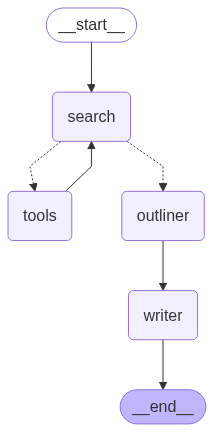

In [30]:
# Visualize Graph
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Test it out!

In [32]:
# Test it out!
from langchain_core.messages import HumanMessage

input_message = HumanMessage(content="generate an article about new trends in AI")

for event in graph.stream({"messages": [input_message]}, stream_mode="values"):
  event['messages'][-1].pretty_print()

================================ Human Message =================================

generate an article about new trends in AI
Invoking Search Agent with state: {'messages': [HumanMessage(content='generate an article about new trends in AI', additional_kwargs={}, response_metadata={}, id='0acc5eff-f552-4770-b16b-ed9beee5d3b4')]}
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (08852359-754c-4826-a7b7-17a41ac0da53)
 Call ID: 08852359-754c-4826-a7b7-17a41ac0da53
  Args:
    query: new trends in AI
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "5 AI Trends Shaping Innovation and ROI in 2025 | Morgan Stanley", "url": "https://www.morganstanley.com/insights/articles/ai-trends-reasoning-frontier-models-2025-tmt", "content": "The top trends in new AI frontiers and the focus on enterprises include AI reasoning, custom silicon, cloud migrations,